<a href="https://colab.research.google.com/github/HarlinLee/cogsci-missed-connections/blob/main/content_context_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import pickle
import networkx as nx

In [ ]:
from google.colab import drive
drive.mount('/content/drive') 
DRIVE_PATH = "/content/drive/My Drive/REU evolution of scientific fields"

Mounted at /content/drive


# Load Topic Modeling and Graph Community Results

In [ ]:
with open(os.path.join(DRIVE_PATH, 'topics_df.pkl'), 'rb') as f:
  topics_df = pickle.load(f)

topic_id_to_keyword = dict(zip(topics_df['SupertopicId'], topics_df['SupertopicKeywords'].apply(lambda x: x[0])))
topic_id_to_keyword2 = dict(zip(topics_df['SupertopicId'], topics_df['SupertopicKeywords'].apply(lambda x: ','.join(x[:2]))))
topic_id_to_keyword3 = dict(zip(topics_df['SupertopicId'], topics_df['SupertopicKeywords'].apply(lambda x: ','.join(x[:3]))))

In [ ]:
tmp = np.load(DRIVE_PATH+'/comm_detection.npz', allow_pickle=True)
community_dict_sorted = tmp['community_dict_sorted'].item()
comm_id_sort = tmp['comm_id_sort'].item()
comm_id_sort_reverse = tmp['comm_id_sort_reverse'].item()
c = tmp['c'].item()

# Topic Distribution

In [ ]:
df = pd.DataFrame.from_dict(c, orient='index').rename(columns={0:'Community'})
df['Community'] = df['Community'].map(comm_id_sort_reverse)
df = topics_df.join(df, how = 'inner')
df = pd.crosstab(index=df['Community'], columns=df['SupertopicId'])
#df

In [ ]:
colors_list = ['#C6CAFB','#646EF7','#70F8C9','#58D4F4','#EF95FB','#FACB51','#EE553B',
               '#F4A058','#F4A799','#AB62F8','#B6E880','#FADBC0','#E0C6FC','#5CCD97','#EE6390']

def plot_comm_pie_chart(comm_id):
  # Pie chart, where the slices will be ordered and plotted counter-clockwise:
  nonzero_bools = (df.iloc[comm_id,:] !=0)
  subset = df.iloc[comm_id,:][nonzero_bools]
  sizes = subset.sort_values(ascending=False)
  labels = sizes.index
  word_labels = [topic_id_to_keyword3[i] for i in labels]
  colors = [colors_list[i] for i in labels]

  def absolute_value(val):
    a  = int(val*sizes.sum()/100)
    if a > sizes.sum()/100*4:
      return a
    else:
      return ""

  fig1, ax1 = plt.subplots(figsize=(12,6))
  pie1 = ax1.pie(sizes, autopct = absolute_value,textprops={'fontsize':20},
        shadow=False, startangle=90, counterclock=False, labels=['']*len(sizes),
        colors = colors)
  
  plt.legend(pie1[0],word_labels, bbox_to_anchor=(1, 0, 0.5, 1), fontsize=16)
  
  ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
  plt.title('Community ' + str(comm_id), fontsize= 24)
  plt.tight_layout()
  plt.savefig(DRIVE_PATH+'/'+'Community'+ str(comm_id)+'.pdf',bbox_inches='tight')
  plt.savefig(DRIVE_PATH+'/'+'CommunityLegend.png',bbox_inches='tight')
  plt.show()

In [ ]:
df_norm = df.apply(lambda x: x/np.linalg.norm(x), axis=1) #l2 normalized
dot_topics = df_norm.dot(df_norm.T)
#dot_topics

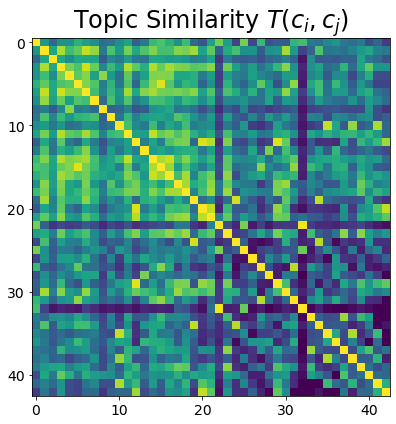

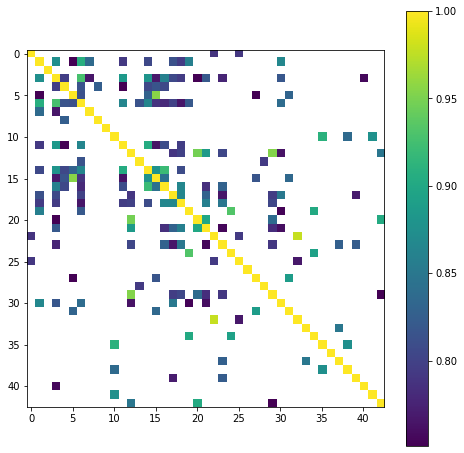

In [ ]:
plt.figure(figsize=(8,6))
plt.imshow(dot_topics)
plt.tick_params(labelsize=14)
plt.yticks(range(0,len(dot_topics), 10))
plt.title('Topic Similarity $T(c_i, c_j)$', fontsize=24)
plt.tight_layout()
plt.savefig(DRIVE_PATH+'/'+'topic_similarity.pdf',bbox_inches='tight')
plt.show() 

plt.figure(figsize=(8,8))
plt.imshow(dot_topics[dot_topics > 0.75])
plt.colorbar() 
plt.show()

# Journal Distribution

In [100]:
with open(os.path.join(DRIVE_PATH, 'filtered_new_fields_df.pkl'), 'rb') as file:
    fields_df = pickle.load(file)
print(fields_df.shape)

id_to_published_in = dict(zip(fields_df['Id'], 
                              fields_df['J'].apply(lambda x: x['JN'] if isinstance(x, dict) else [])))
id_to_affili_name = dict(zip(fields_df['Id'], 
                             fields_df['AA'].apply(lambda x: [y['AfN'] for y in x if 'AfN' in y] if isinstance(x, list) and len(x) > 0 else []) ))
id_to_affili_Id = dict(zip(fields_df['Id'], 
                           fields_df['AA'].apply(lambda x: [y['AfId'] for y in x if 'AfId' in y] if isinstance(x, list) and len(x) > 0 else []) ))
id_to_author_name = dict(zip(fields_df['Id'], 
                             fields_df['AA'].apply(lambda x: [y['AuN'] for y in x if 'AuN' in y] if isinstance(x, list) and len(x) > 0 else []) ))
id_to_author_Id = dict(zip(fields_df['Id'], 
                           fields_df['AA'].apply(lambda x: [y['AuId'] for y in x if 'AuId' in y] if isinstance(x, list) and len(x) > 0 else []) ))

del fields_df

(59384, 18)


In [105]:
#Returns list of journals in a community
def list_community_journals(comm_id):
  comm_journals = [id_to_published_in[i] for i in community_dict_sorted[comm_id]]
  comm_journals = [i for i in comm_journals if not isinstance(i,list)]
  return comm_journals

def list_affili_names(comm_id):
  affili_names = [name for i in community_dict_sorted[comm_id] for name in id_to_affili_name[i]]
  # affili_names = [i for i in affili_names if not isinstance(i,list)]
  return affili_names

def list_author_names(comm_id):
  author_names = [name for i in community_dict_sorted[comm_id] for name in id_to_author_name[i]]
  return author_names

In [ ]:
def journal_inner(i,j): #Computes inner product of journal distributions
  journals_counts1 = pd.Series(list_community_journals(i)).value_counts()
  journals_counts2 = pd.Series(list_community_journals(j)).value_counts()
  norm1 = np.linalg.norm(journals_counts1)
  norm2 = np.linalg.norm(journals_counts2)
  journals1 = journals_counts1.apply(lambda x: x/norm1) #l2 normalized
  journals2 = journals_counts2.apply(lambda x: x/norm2)
  return pd.Series.mul(journals1,journals2, fill_value=0).sum() #mul aligns then multiplies (0 if one doesn't have)

dot_journal = np.zeros((len(community_dict_sorted),len(community_dict_sorted)))
for i in range(len(community_dict_sorted)): #Not optimized, takes ~10 sec
  for j in range(len(community_dict_sorted)): 
    dot_journal[i,j] = journal_inner(i, j)
dot_journal = pd.DataFrame(dot_journal)

In [ ]:
community_size = {}
for id, comm in community_dict_sorted.items():
  community_size[id] = len(comm)

community_size = pd.Series(community_size)

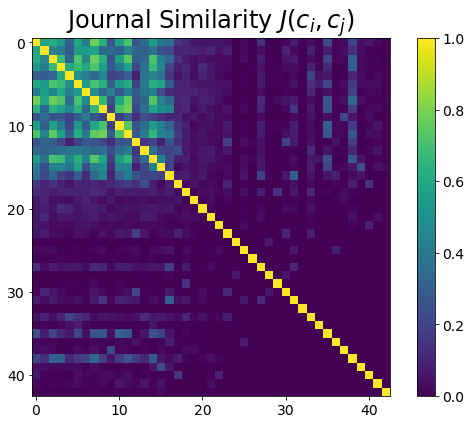

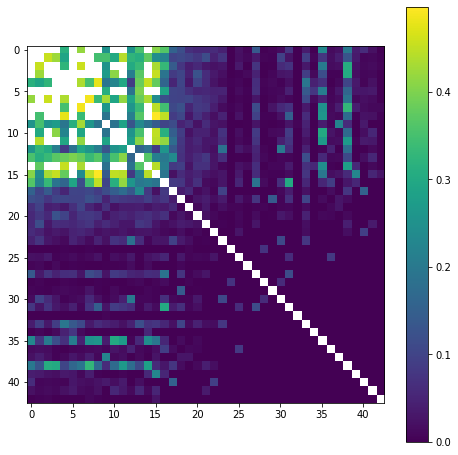

In [ ]:
plt.figure(figsize=(8,6))
plt.imshow(dot_journal)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)
plt.tick_params(labelsize=14)
plt.yticks(range(0,len(dot_topics), 10))
plt.title('Journal Similarity $J(c_i, c_j)$', fontsize=24)
plt.tight_layout()
plt.savefig(DRIVE_PATH+'/'+'journal_similarity.pdf',bbox_inches='tight')
plt.show() 

plt.figure(figsize=(8,8))
plt.imshow(dot_journal[dot_journal < 0.5])
plt.colorbar() 
plt.show()

# Identify Regions of Interest, i.e. content-context discrepancy

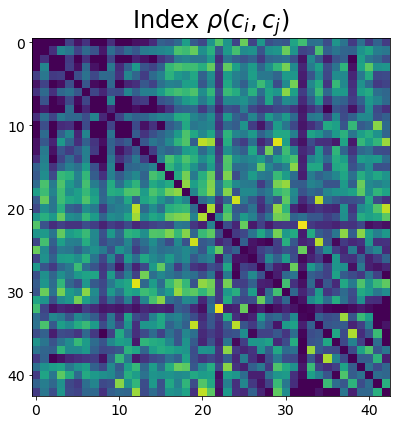

In [ ]:
diff_index = dot_topics-dot_journal

plt.figure(figsize=(8,6))
plt.imshow(diff_index, vmin=0, vmax=1)
plt.tick_params(labelsize=14)
plt.yticks(range(0,len(dot_topics), 10))
plt.title(r'Index $\rho(c_i, c_j)$', fontsize=24)
plt.tight_layout()
plt.savefig(DRIVE_PATH+'/'+'diff_index.pdf',bbox_inches='tight')
plt.show() 


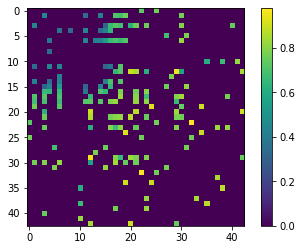

In [ ]:
mask = np.multiply(dot_topics > 0.75, dot_journal < 0.5)
diff_index_mask = np.multiply(mask, diff_index)
plt.imshow(diff_index_mask)
plt.colorbar()
plt.show()

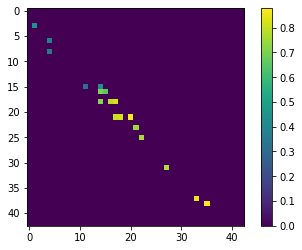

In [ ]:
mask = np.multiply(mask, np.tril(np.ones(dot_topics.shape),-1) - np.tril(np.ones(dot_topics.shape), -5))
diff_index_mask = np.multiply(mask, diff_index_mask)
plt.imshow(diff_index_mask)
plt.colorbar()
plt.show()

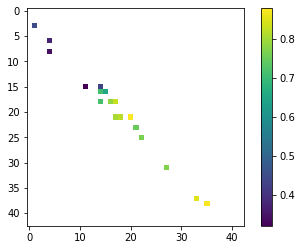

In [ ]:
diff_index_mask = diff_index_mask[diff_index_mask > 0]
plt.imshow(diff_index_mask)
plt.colorbar()
plt.show()

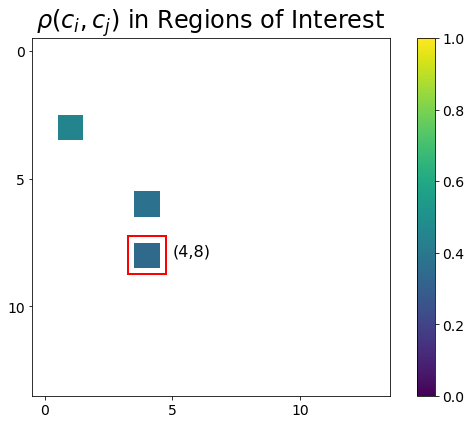

In [ ]:
bool_mask = community_size > 1000
diff_index_mask = diff_index_mask.loc[bool_mask, bool_mask]

plt.figure(figsize=(8,6))
plt.imshow(diff_index_mask, vmin=0, vmax=1)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)
plt.tick_params(labelsize=14)
plt.yticks(range(0,len(diff_index_mask)+1, 5))
plt.xticks(range(0,len(diff_index_mask)+1, 5))
plt.gca().add_patch(Rectangle((3.25,7.25),1.5,1.5,linewidth=2,edgecolor='r',facecolor='none'))
plt.text(5,8, '(4,8)', fontsize=16)
plt.title(r'$\rho(c_i, c_j)$ in Regions of Interest', fontsize=24)
plt.tight_layout()
plt.savefig(DRIVE_PATH+'/'+'diff_index_oi.pdf',bbox_inches='tight')
plt.show() 

3 pairs of interest
====
0 th pair: communities [3 1]
rho: 0.4504 T: 0.8754 J: 0.425


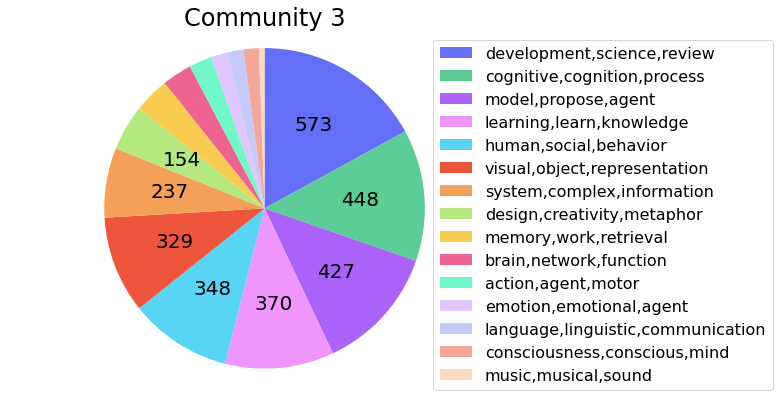

Journals of community 3
behavioral and brain sciences                                       104
cognition                                                            84
cognitive science                                                    61
quarterly journal of experimental psychology                         61
trends in cognitive sciences                                         54
journal of experimental psychology learning memory and cognition     51
psychology of learning and motivation                                50
psychological review                                                 47
psychonomic bulletin & review                                        40
philosophical psychology                                             39
dtype: int64

Affiliations of community 3
max planck society                        116
university of california los angeles       78
university of california santa barbara     70
indiana university                         68
yale university               

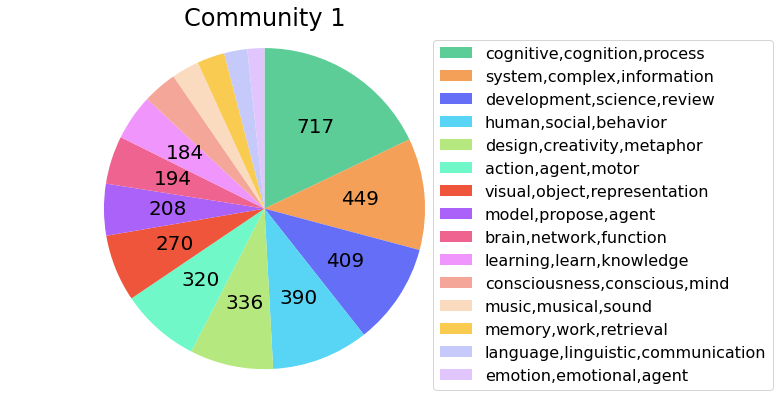

Journals of community 1
phenomenology and the cognitive sciences    129
frontiers in psychology                      91
philosophical psychology                     74
cognitive systems research                   55
synthese                                     54
new ideas in psychology                      54
behavioral and brain sciences                49
minds and machines                           48
ecological psychology                        45
adaptive behavior                            44
dtype: int64

Affiliations of community 1
university of sussex                95
university of the basque country    88
university of connecticut           78
university of edinburgh             73
vu university amsterdam             66
indiana university                  61
university of skovde                57
university college london           57
university of cincinnati            57
university of hertfordshire         55
dtype: int64

Authors of community 1
ezequiel a di paolo    51
s

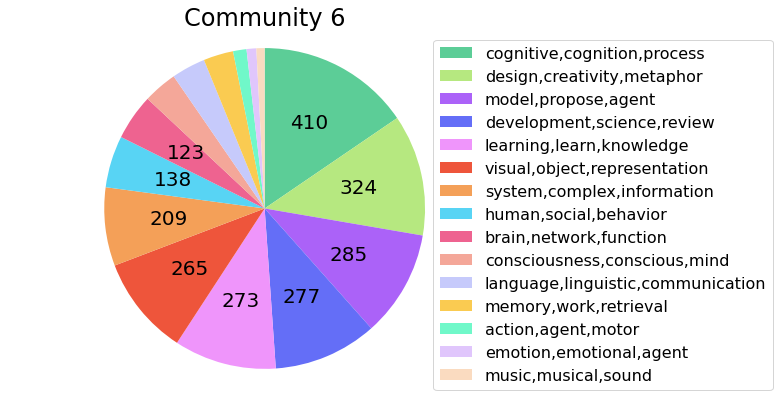

Journals of community 6
minds and machines                                                 98
cognitive science                                                  59
philosophical psychology                                           56
behavioral and brain sciences                                      51
synthese                                                           34
design studies                                                     31
journal of experimental and theoretical artificial intelligence    27
advances in psychology                                             26
topics in cognitive science                                        23
ai & society                                                       22
dtype: int64

Affiliations of community 6
carnegie mellon university                    93
northwestern university                       89
university of california los angeles          65
university of california berkeley             60
indiana university                    

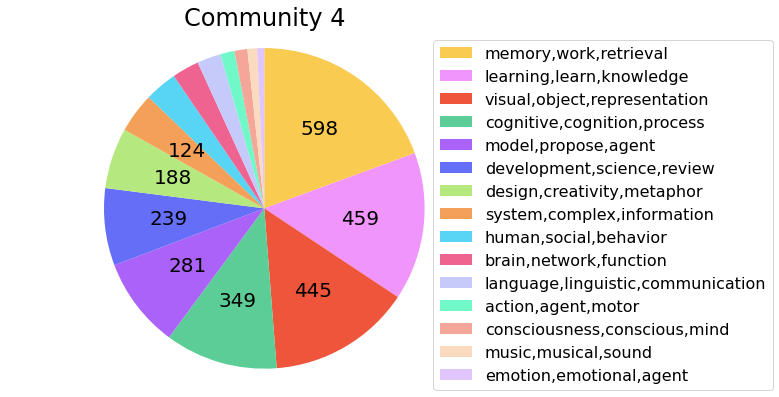

Journals of community 4
advances in psychology                                              78
memory & cognition                                                  66
journal of experimental psychology learning memory and cognition    63
applied cognitive psychology                                        61
educational psychologist                                            52
educational psychology review                                       44
psychology of learning and motivation                               43
journal of educational psychology                                   35
psychonomic bulletin & review                                       34
memory                                                              32
dtype: int64

Affiliations of community 4
university of michigan                90
university of new south wales         59
carnegie mellon university            53
university of toronto                 47
indiana university                    41
university of washi

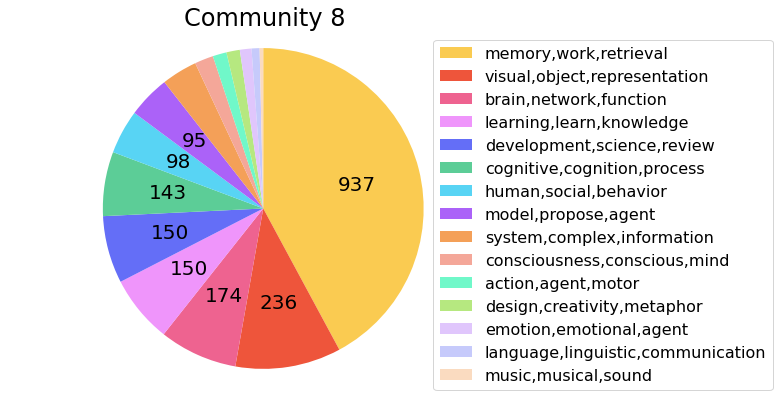

Journals of community 8
trends in cognitive sciences            84
behavioral and brain sciences           50
biorxiv                                 47
frontiers in human neuroscience         35
neuropsychologia                        34
journal of cognitive neuroscience       33
current biology                         30
neuron                                  30
neuroscience & biobehavioral reviews    30
memory                                  29
dtype: int64

Affiliations of community 8
university college london         168
harvard university                128
university of toronto             112
boston university                  76
university of oxford               61
university of california davis     58
university of cambridge            53
university of arizona              52
max planck society                 52
columbia university                52
dtype: int64

Authors of community 8
daniel l schacter      43
howard eichenbaum      27
lynn nadel             25
donna ros

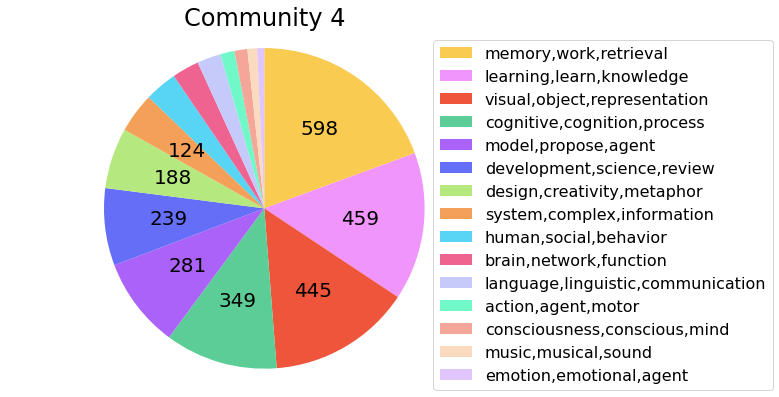

Journals of community 4
advances in psychology                                              78
memory & cognition                                                  66
journal of experimental psychology learning memory and cognition    63
applied cognitive psychology                                        61
educational psychologist                                            52
educational psychology review                                       44
psychology of learning and motivation                               43
journal of educational psychology                                   35
psychonomic bulletin & review                                       34
memory                                                              32
dtype: int64

Affiliations of community 4
university of michigan                90
university of new south wales         59
carnegie mellon university            53
university of toronto                 47
indiana university                    41
university of washi

In [107]:
pairs_oi = np.array(diff_index_mask.stack().index.tolist())
diff_index_oi = np.array([diff_index_mask.iloc[p[0],p[1]] for p in pairs_oi])
idx = np.argsort(diff_index_oi).astype(int)[::-1]
diff_index_oi, pairs_oi = diff_index_oi[idx], pairs_oi[idx]

print(len(pairs_oi), 'pairs of interest')
print('====')

for ii, p in enumerate(pairs_oi):
  print(ii, 'th pair:', 'communities', p)
  print('rho:', np.around(diff_index_oi[ii],4), 
        'T:', np.around(dot_topics.iloc[p[0], p[1]],4), 
        'J:', np.around(dot_journal.iloc[p[0], p[1]],4))
  for comm in p:
    plot_comm_pie_chart(comm)
    print("Journals of community", comm)
    print(pd.Series(list_community_journals(comm)).value_counts()[:10])
    print()
    print("Affiliations of community", comm)
    print(pd.Series(list_affili_names(comm)).value_counts()[:10])
    print()
    print("Authors of community", comm)
    print(pd.Series(list_author_names(comm)).value_counts()[:10])
    print()
    print()
  print('=====')